# Parameter Estimation of RIG Roll Experiments

## Setup and descriptions

* Without ACM model
* Turn on wind tunnel
* Only 1DoF for RIG roll movement
* Use **small-amplitude** aileron command of CMP as inputs (in degrees)
$$U = \delta_{a,cmp}(t)$$
* Consider RIG roll angle and its derivative as States (in radians)
$$X = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Observe RIG roll angle and its derivative as Outputs (in degrees)
$$Z = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Use output error method based on most-likehood(ML) to estimate
$$ \theta = \begin{pmatrix} C_{l,\delta_a,cmp} \\ C_{lp,cmp}  \end{pmatrix} $$

## Startup computation engines

In [1]:
%run matt_startup
%run -i matt_utils

button_qtconsole()

#import other needed modules in all used engines
#with dview.sync_imports():
#   import os

importing numpy on engine(s)
importing scipy on engine(s)
importing matplotlib on engine(s)
importing scipy.integrate on engine(s)
importing scipy.interpolate on engine(s)
importing math on engine(s)
importing time on engine(s)
importing itertools on engine(s)
importing random on engine(s)


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Data preparation

### Load raw data

In [2]:
filename = 'FIWT_Exp052_20150616144645.dat.npz'

def loadData():
    # Read and parse raw data
    global exp_data
    exp_data = np.load(filename)

    # Select colums
    global T_cmp, da1_cmp, da2_cmp, da3_cmp , da4_cmp
    T_cmp = exp_data['data33'][:,0]
    da1_cmp = exp_data['data33'][:,3]
    da2_cmp = exp_data['data33'][:,5]
    da3_cmp = exp_data['data33'][:,7]
    da4_cmp = exp_data['data33'][:,9]

    global T_rig, phi_rig
    T_rig = exp_data['data44'][:,0]
    phi_rig = exp_data['data44'][:,2]

loadData()

In [3]:
text_loadData()

(28, 32)

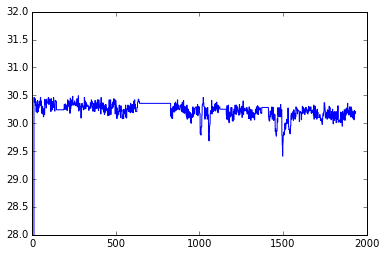

In [4]:

V = exp_data['data44'][:,13]
%matplotlib inline
plt.plot(T_rig, V*1.05)
plt.ylim((28,32))

### Check time sequence and inputs/outputs

Click 'Check data' button to show the raw data. 

Click on curves to select time point and push into queue; click 'T/s' text to pop up last point in the queue; and click 'Output' text to print time sequence table.

In [5]:
def checkInputOutputData():

    #check inputs/outputs
    fig, ax = plt.subplots(2,1,True)
    ax[0].plot(T_cmp,da1_cmp,'r', T_cmp,da2_cmp,'g',
               T_cmp,da3_cmp,'b', T_cmp,da4_cmp,'m',
               picker=1)
    ax[1].plot(T_rig,phi_rig, 'b', picker=2)
    ax[0].set_ylabel('$\delta \/ / \/ ^o$')
    ax[1].set_ylabel('$\phi \/ / \/ ^o/s$')
    ax[1].set_xlabel('$T \/ / \/ s$', picker=True)
    ax[0].set_title('Output', picker=True)
    

    fig.canvas.mpl_connect('pick_event', onPickTime)
    fig.show()
    display(fig)

button_CheckData()

### Input $\delta_T$ and focused time ranges

In [6]:
# Pick up focused time ranges
time_marks = [
[18.8573202878,137.312699085,"ramp cmp4 u"],
[141.408935166,260.27090166,"ramp cmp4 d"],
[265.592177186,384.456691192,"ramp cmp3 u"],
[391.487466737,509.969548357,"ramp cmp3 d"],
[518.478950349,638.264844453,"ramp cmp2 u"],
[644.71182051,763.983487372,"ramp cmp2 d"],
[770.300044567,889.812031944,"ramp cmp1 u"],
[895.995020394,1014.85848293,"ramp cmp1 d"],
[1022.19234822,1141.45367229,"ramp cmp4 d"],
[1145.14958662,1265.23165475,"ramp cmp4 u"],
[1279.28149733,1397.62176653,"ramp cmp3 u"],
[1411.53843282,1530.01180295,"ramp cmp2 d"],
[1536.98628003,1657.06650374,"ramp cmp2 u"],
[1671.68321255,1792.31335791,"ramp cmp1 d"],
[1798.33449076,1918.9341565,"ramp cmp1 u"],
]

# Decide DT,U,Z and their processing method
DT=0.2
process_set = {
            'U':[(T_cmp, da1_cmp,0),
                (T_cmp, da2_cmp,0),
                (T_cmp, da3_cmp,0),
                (T_cmp, da4_cmp,0),],
            'Z':[(T_rig, phi_rig,1),],
            'cutoff_freq': 1 #Hz
           }

U_names = ['$\delta_{a1,cmp} \, / \, ^o$',
          '$\delta_{a2,cmp} \, / \, ^o$',
          '$\delta_{a3,cmp} \, / \, ^o$',
          '$\delta_{a4,cmp} \, / \, ^o$']
Y_names = Z_names = ['$\phi_{a,rig} \, / \, ^o$']

display_data_prepare()

<IPython.core.display.Math object>

Idx,Start(s),Spam(s),Description
0,18.86,118.46,ramp cmp4 u
1,141.41,118.86,ramp cmp4 d
2,265.59,118.86,ramp cmp3 u
3,391.49,118.48,ramp cmp3 d
4,518.48,119.79,ramp cmp2 u
5,644.71,119.27,ramp cmp2 d
6,770.30,119.51,ramp cmp1 u
7,896.00,118.86,ramp cmp1 d
8,1022.19,119.26,ramp cmp4 d
9,1145.15,120.08,ramp cmp4 u


$U$
"$\delta_{a1,cmp} \, / \, ^o$"
"$\delta_{a2,cmp} \, / \, ^o$"
"$\delta_{a3,cmp} \, / \, ^o$"
"$\delta_{a4,cmp} \, / \, ^o$"


$Z$
"$\phi_{a,rig} \, / \, ^o$"


## Resample and filter data in sections

For each section,
* Select time range and shift it to start from zero;
* Resample Time, Inputs, Outputs in unique $\delta_T$;
* Smooth Input/Observe data if flag bit0 is set;
* Take derivatives of observe data if flag bit1 is set.

In [7]:
resample(True);

## Define dynamic model to be estimated

$$\left\{\begin{matrix}\begin{align}
M_{x,rig} &= M_{x,a} + M_{x,f} + M_{x,cg} = 0 \\
M_{x,a} &= \frac{1}{2} \rho V^2S_cb_c  C_{la,cmp}\delta_{a,cmp} \\
M_{x,f} &= -F_c \, sign(\dot{\phi}_{rig}) \\
M_{x,cg} &= -m_T g  l_{zT} \sin \left ( \phi - \phi_0 \right )
\end{align}\end{matrix}\right.$$



In [19]:
%%px --local
#update common const parameters in all engines

angles = range(-40,41,5)
angles[0] -= 1
angles[-1] += 1
del angles[angles.index(0)]
angles_num = len(angles)

#problem size
Nx = 0
Nu = 4
Ny = 1
Npar = 4*angles_num+1

#reference
S_c = 0.1254   #S_c(m2) 
b_c = 0.7      #b_c(m)
g = 9.81       #g(m/s2)

#static measurement
m_T = 9.585   #m_T(kg)
l_z_T = 0.0416 #l_z_T(m)
V = 30         #V(m/s)

#previous estimations
F_c = 0.06 #F_c(N*m)
Clda_cmp = -0.2966 #Clda_cmp(1/rad)

#for short
qbarSb = 0.5*1.225*V*V*S_c*b_c
_m_T_l_z_T_g = -(m_T*l_z_T)*g


def obs(Z,T,U,params):
    s = T.size
    
    k1 = np.array(params[0:angles_num])
    k2 = np.array(params[angles_num:angles_num*2])
    k3 = np.array(params[angles_num*2:angles_num*3])
    k4 = np.array(params[angles_num*3:angles_num*4])
    phi0 = params[-1]

    Clda1 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k1*angles,assume_sorted=True)
    Clda2 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k2*angles,assume_sorted=True)
    Clda3 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k3*angles,assume_sorted=True)
    Clda4 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k4*angles,assume_sorted=True)
    
    moments_a = qbarSb*(Clda1(U[:s,0])+Clda2(U[:s,1])
                       +Clda3(U[:s,2])+Clda4(U[:s,3]))

    phi = phi0+np.arcsin(np.clip(-moments_a/_m_T_l_z_T_g, -1, 1))
    
    return (phi*57.3).reshape((-1,1))



In [20]:
display(HTML('<b>Constant Parameters</b>'))
table = ListTable()
table.append(['Name','Value','unit'])
table.append(['$S_c$',S_c,'$m^2$'])
table.append(['$b_c$',b_c,'$m$'])
table.append(['$g$',g,'$m/s^2$'])
table.append(['$m_T$',m_T,'$kg$'])
table.append(['$l_{zT}$',l_z_T,'$m$'])
table.append(['$V$',V,'$m/s$'])
table.append(['$F_c$',F_c,'$Nm$'])
table.append(['$C_{l \delta a,cmp}$',Clda_cmp,'$rad^{-1}$'])
display(table)


Name,Value,unit
$S_c$,0.1254,$m^2$
$b_c$,0.7,$m$
$g$,9.81,$m/s^2$
$m_T$,9.585,$kg$
$l_{zT}$,0.0416,$m$
$V$,30,$m/s$
$F_c$,0.06,$Nm$
"$C_{l \delta a,cmp}$",-0.2966,$rad^{-1}$


# Initial guess

* Input default values and ranges for parameters
* Select sections for trainning
* Adjust parameters based on simulation results
* Decide start values of parameters for optimization

In [21]:
#initial guess
param0 = [1]*(4*angles_num)+[0]

param_name = ['k_{}_{}'.format(i/angles_num+1, angles[i%angles_num]) for i in range(4*angles_num)] + ['$phi_0$']
param_unit = ['1']*(4*angles_num) + ['$rad$']

NparID = Npar
opt_idx = range(Npar)
opt_param0 = [param0[i] for i in opt_idx]
par_del = [0.001]*(4*angles_num) + [0.0001]
bounds =  [(0,1.5)]*(4*angles_num) +[(-0.1, 0.1)]
display_default_params()

#select sections for training
section_idx = range(14)
display_data_for_train()

#push parameters to engines
push_opt_param()

Idx,Description,$x_0$,unit,opt,$\delta_{par}$,min,max
0,k_1_-41,1,1,*,0.001,0,1.5
1,k_1_-35,1,1,*,0.001,0,1.5
2,k_1_-30,1,1,*,0.001,0,1.5
3,k_1_-25,1,1,*,0.001,0,1.5
4,k_1_-20,1,1,*,0.001,0,1.5
5,k_1_-15,1,1,*,0.001,0,1.5
6,k_1_-10,1,1,*,0.001,0,1.5
7,k_1_-5,1,1,*,0.001,0,1.5
8,k_1_5,1,1,*,0.001,0,1.5
9,k_1_10,1,1,*,0.001,0,1.5


Idx,Start(s),Spam(s),Description
0,18.86,118.46,ramp cmp4 u
1,141.41,118.86,ramp cmp4 d
2,265.59,118.86,ramp cmp3 u
3,391.49,118.48,ramp cmp3 d
4,518.48,119.79,ramp cmp2 u
5,644.71,119.27,ramp cmp2 d
6,770.30,119.51,ramp cmp1 u
7,896.00,118.86,ramp cmp1 d
8,1022.19,119.26,ramp cmp4 d
9,1145.15,120.08,ramp cmp4 u


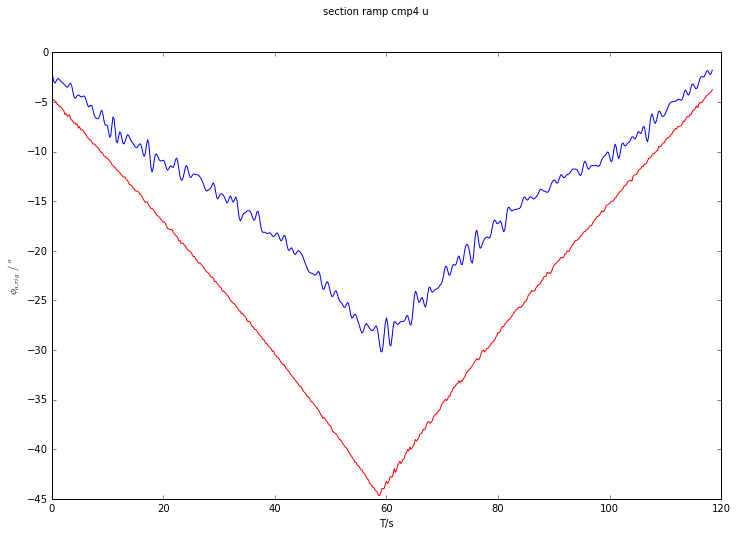

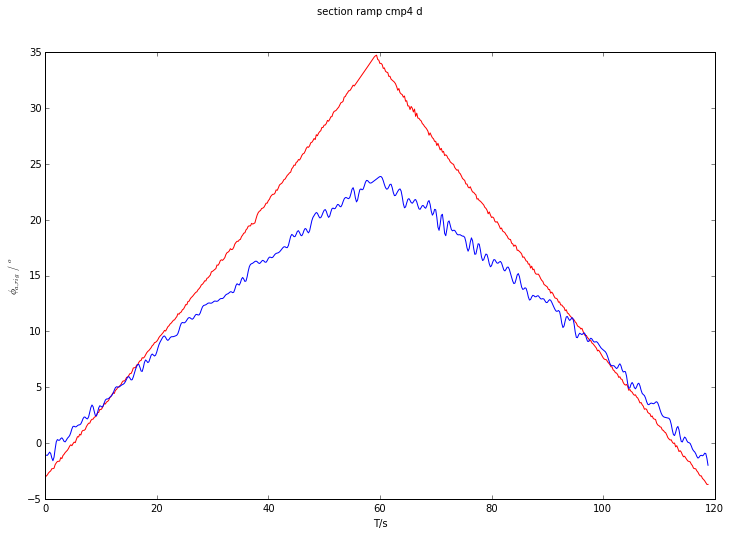

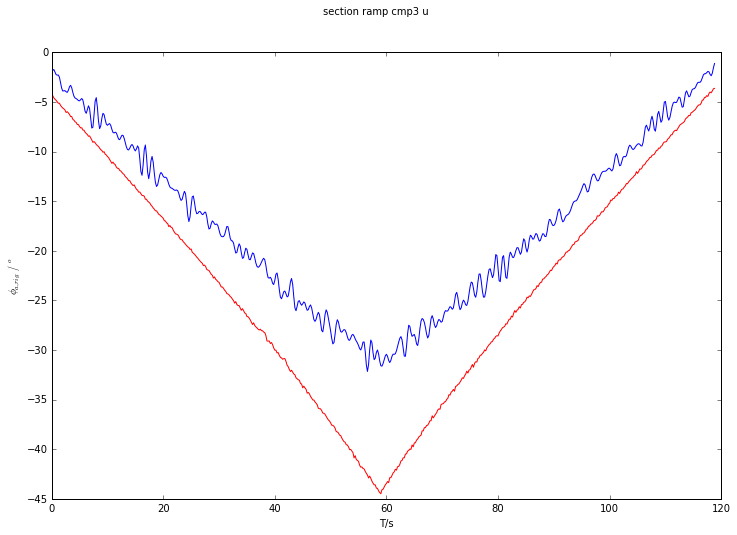

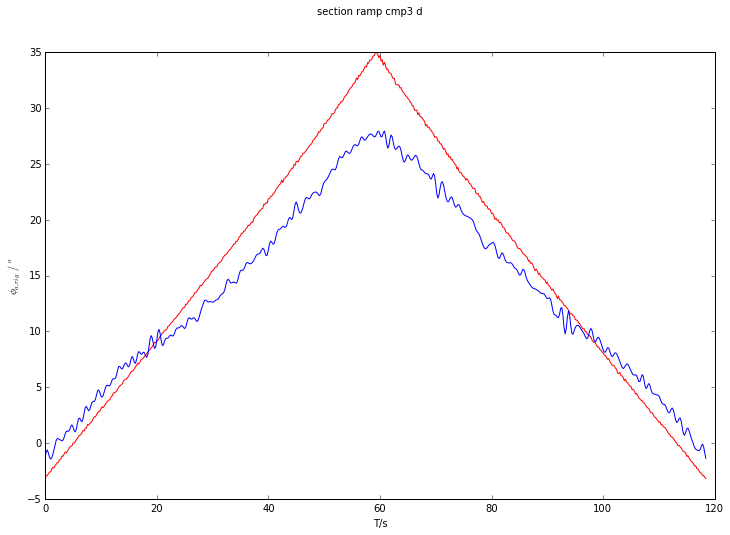

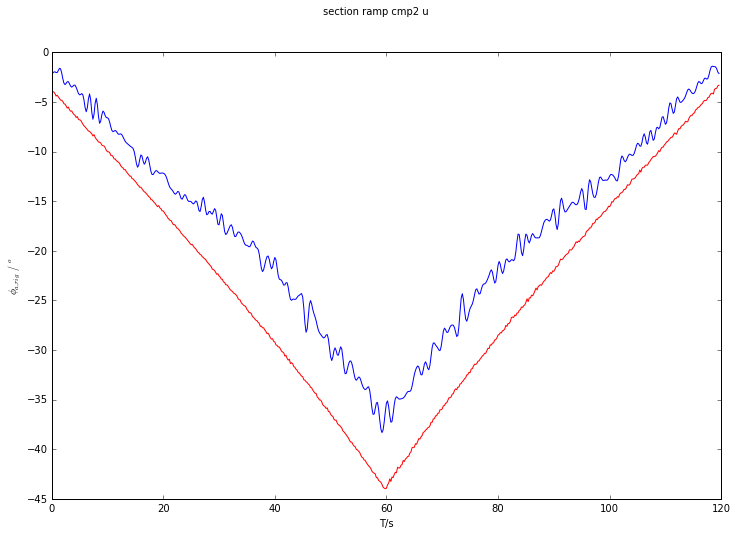

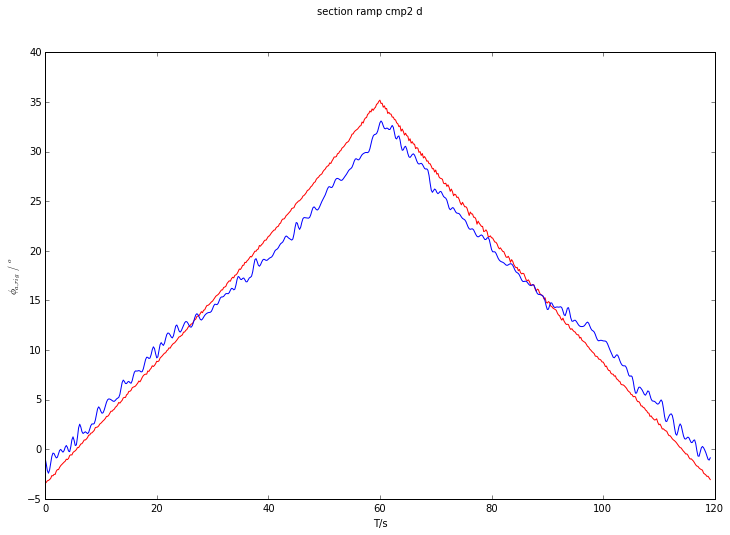

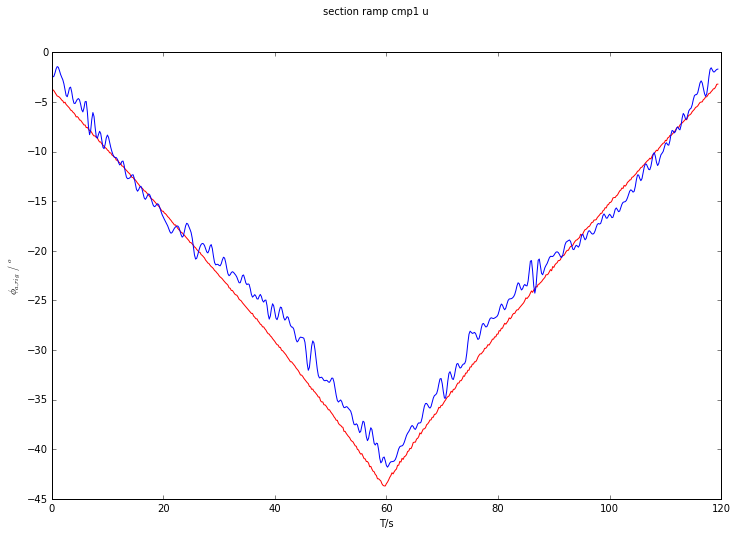

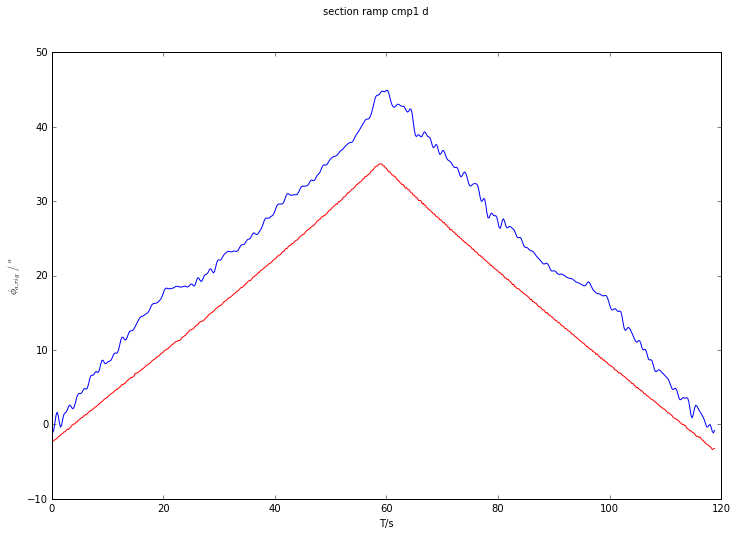

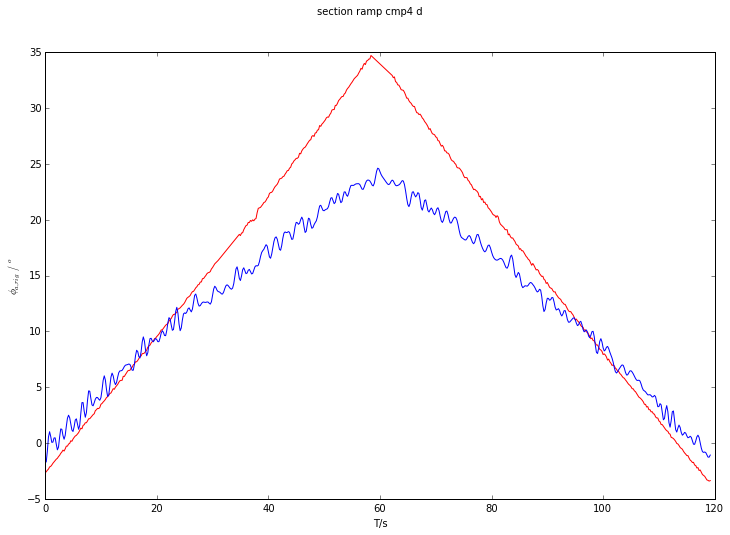

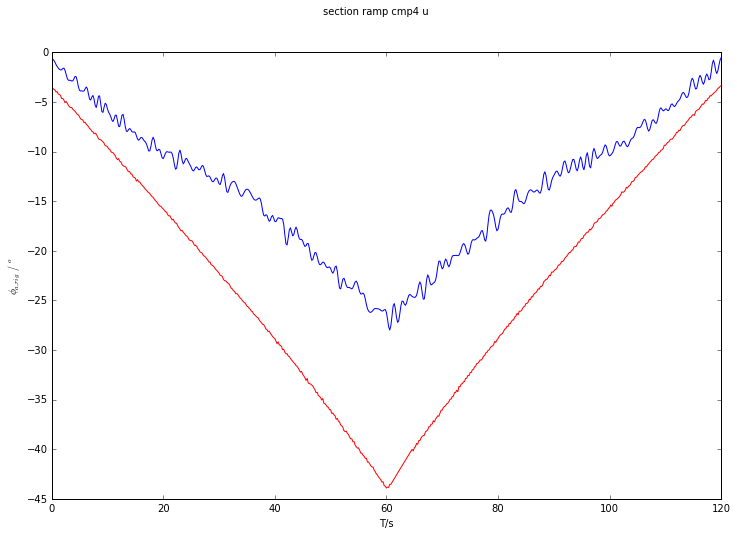

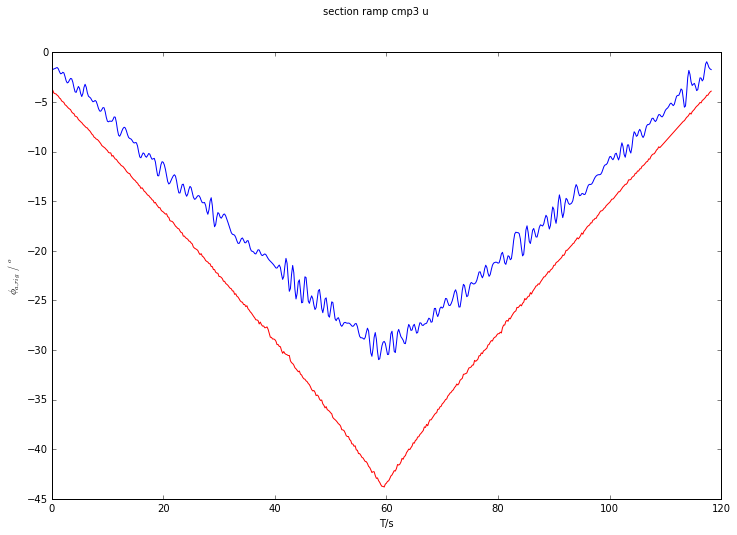

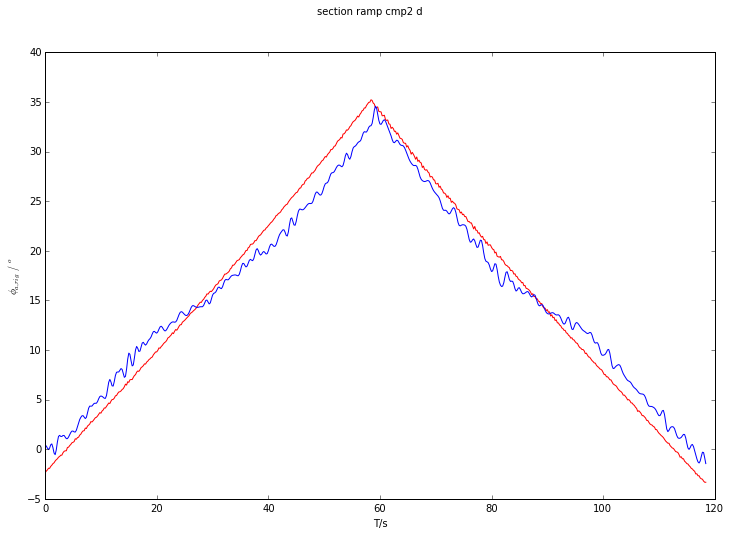

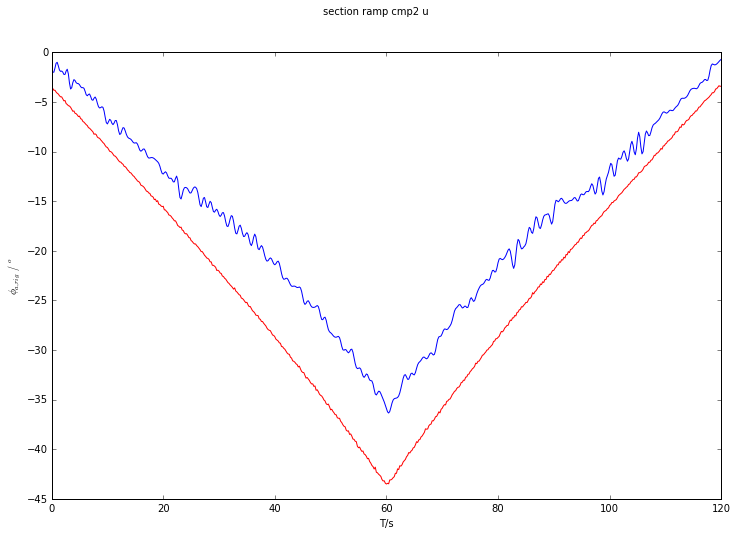

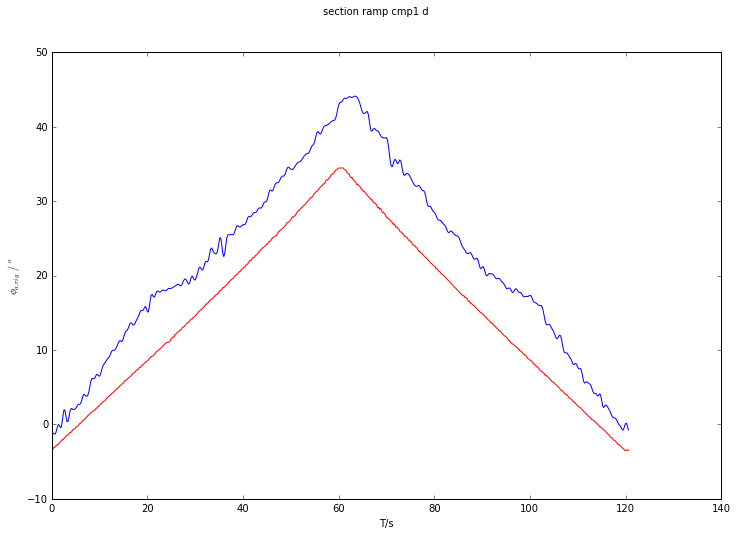

In [22]:
# select 4 section from training data
#idx = random.sample(section_idx, 4)
idx = section_idx[:]

interact_guess();

# Optimize using ML

In [23]:
display_preopt_params()

if False:
    InfoMat = None
    method = 'trust-ncg'
    def hessian(opt_params, index):
        global InfoMat
        return InfoMat
    dview['enable_infomat']=True
    options={'gtol':1}
    opt_bounds = None
else:
    method = 'L-BFGS-B'
    hessian = None
    dview['enable_infomat']=False
    options={'ftol':1e-6,'maxfun':400}
    opt_bounds = bounds

cnt = 0
tmp_rslt = None
T0 = time.time()
print('#cnt,     Time,      |R|')

%time res =  sp.optimize.minimize(fun=costfunc, x0=opt_param0, \
        args=(opt_idx,), method=method, jac=True, hess=hessian, \
        bounds=opt_bounds, options=options)


Idx,Description,$x_0$,unit,opt,$\delta_{par}$,min,max
0,k_1_-41,1.0,1,*,0.001,0,1.5
1,k_1_-35,1.0,1,*,0.001,0,1.5
2,k_1_-30,1.0,1,*,0.001,0,1.5
3,k_1_-25,1.0,1,*,0.001,0,1.5
4,k_1_-20,1.0,1,*,0.001,0,1.5
5,k_1_-15,1.0,1,*,0.001,0,1.5
6,k_1_-10,1.0,1,*,0.001,0,1.5
7,k_1_-5,1.0,1,*,0.001,0,1.5
8,k_1_5,1.0,1,*,0.001,0,1.5
9,k_1_10,1.0,1,*,0.001,0,1.5


#cnt,     Time,      |R|
0001,    0.197,       36.6
0002,    0.350,      686.4
0003,    0.495,       17.3
0004,    0.645,        8.6
0005,    0.781,      101.5
0006,    0.940,       14.5
0007,    1.105,        6.9
0008,    1.270,        7.6
0009,    1.435,        6.3
0010,    1.587,       11.6
0011,    1.725,        7.6
0012,    1.880,        6.6
0013,    2.036,        6.3
0014,    2.187,        6.3
0015,    2.330,        6.6
0016,    2.469,        6.2
0017,    2.610,        6.2
0018,    2.764,        6.0
0019,    2.927,        5.4
0020,    3.102,        5.4
0021,    3.267,        4.8
0022,    3.447,        4.4
0023,    3.619,        4.4
0024,    3.792,        4.4
0025,    3.977,        4.4
0026,    4.157,        4.4
0027,    4.324,        4.4
0028,    4.486,        4.4
0029,    4.629,        4.4
0030,    4.773,        4.4
0031,    4.918,        4.4
0032,    5.056,        4.4
0033,    5.192,        4.4
0034,    5.336,        4.4
0035,    5.470,        4.4
0036,    5.611,        4.4
003

## Show and test results

Idx,Description,$x$
0,k_1_-41,1.14629833042
1,k_1_-35,1.16285127459
2,k_1_-30,1.17710541985
3,k_1_-25,1.1848702943
4,k_1_-20,1.20462684676
5,k_1_-15,1.26263485422
6,k_1_-10,1.2516653674
7,k_1_-5,0.980486789023
8,k_1_5,0.921488273382
9,k_1_10,1.18096915384


Idx,Start(s),Spam(s),Description
0,18.86,118.46,ramp cmp4 u
1,141.41,118.86,ramp cmp4 d
8,1022.19,119.26,ramp cmp4 d
9,1145.15,120.08,ramp cmp4 u
2,265.59,118.86,ramp cmp3 u
3,391.49,118.48,ramp cmp3 d
10,1279.28,118.34,ramp cmp3 u
4,518.48,119.79,ramp cmp2 u
5,644.71,119.27,ramp cmp2 d
11,1411.54,118.47,ramp cmp2 d


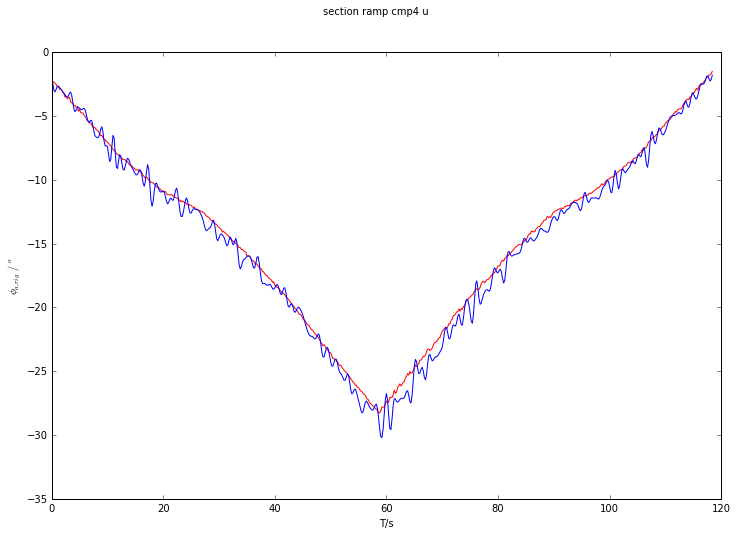

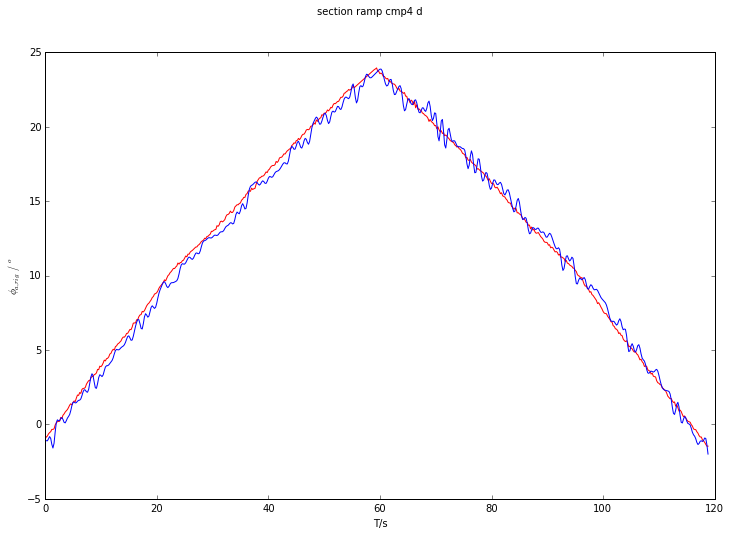

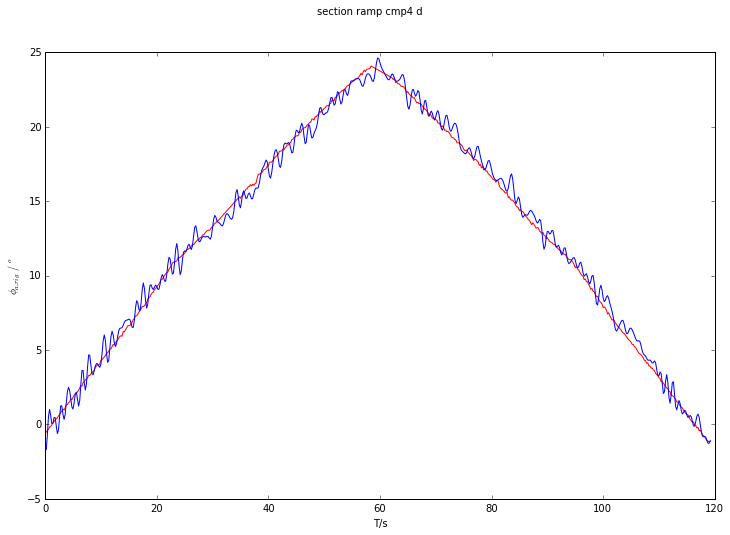

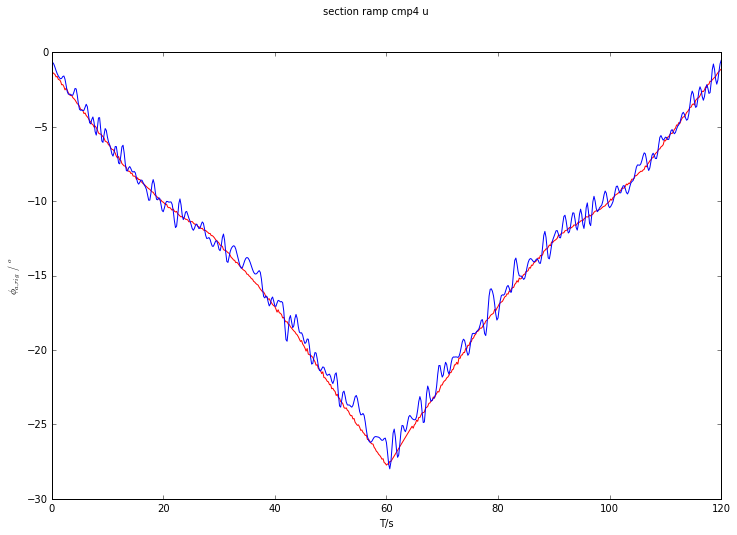

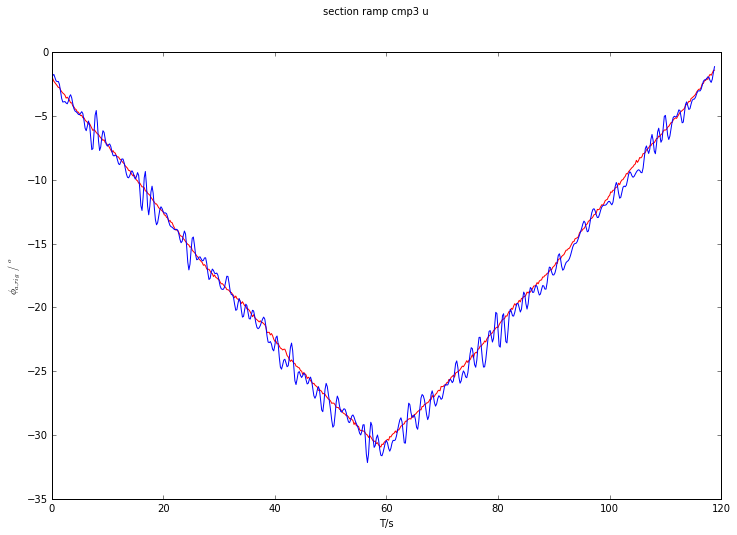

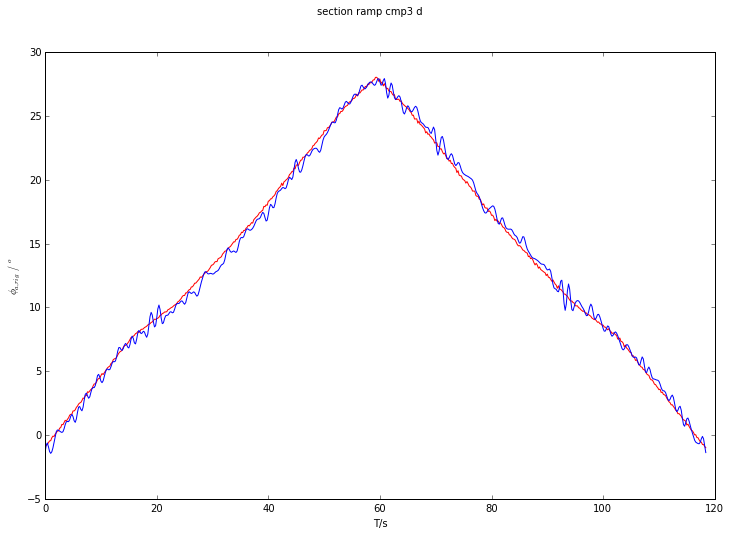

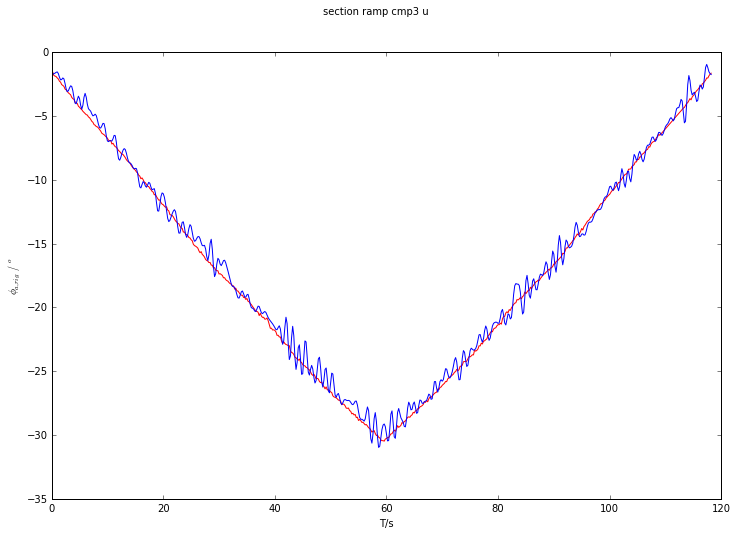

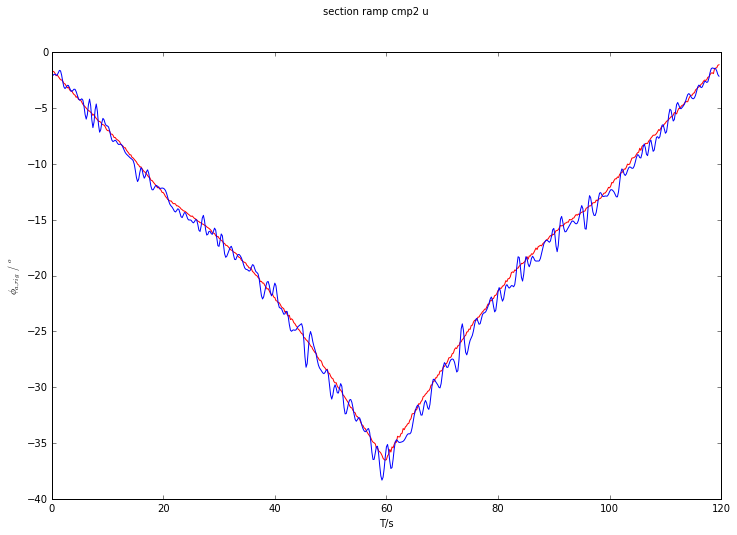

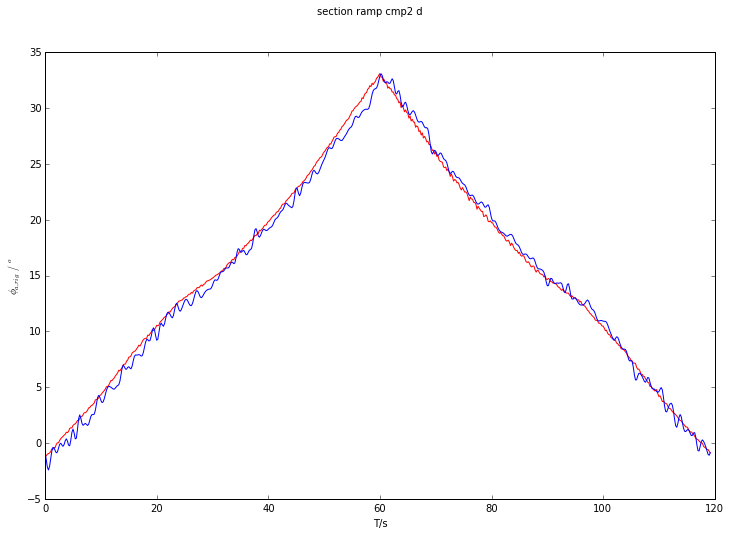

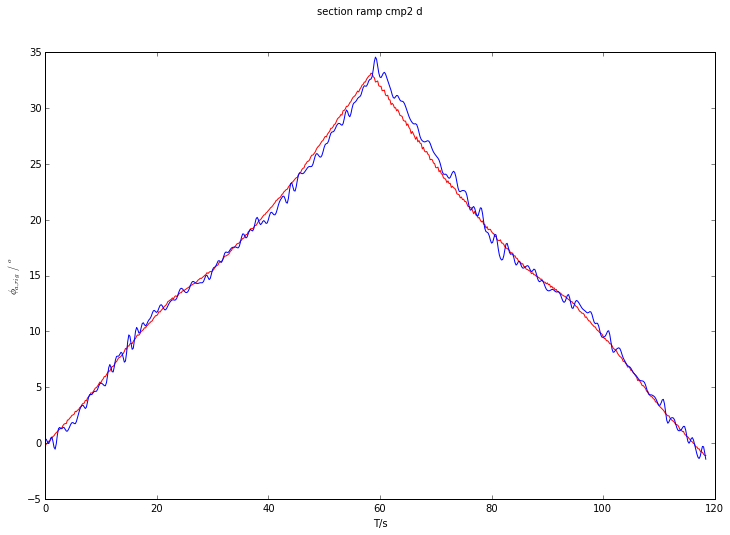

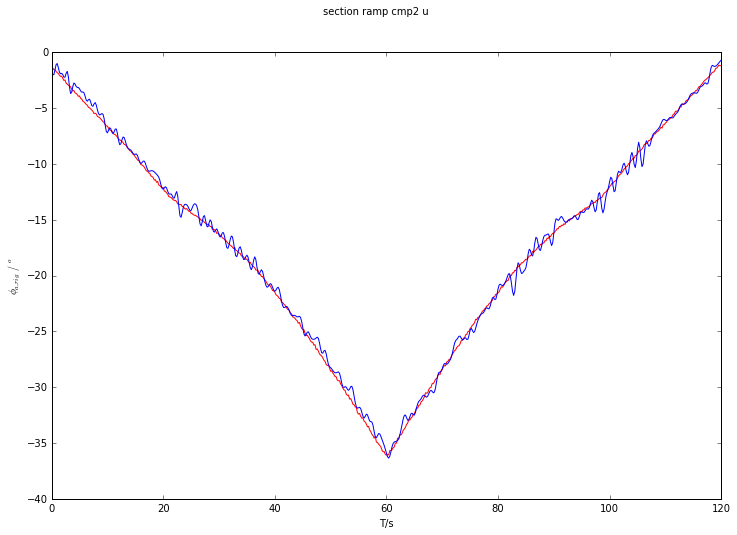

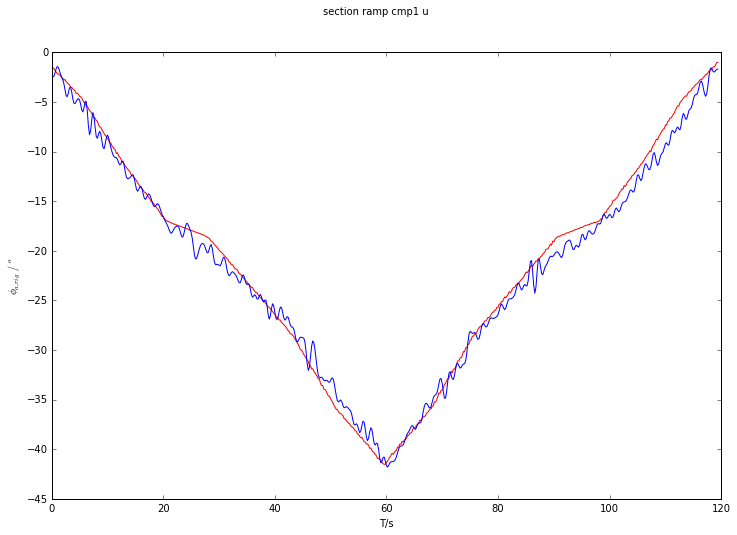

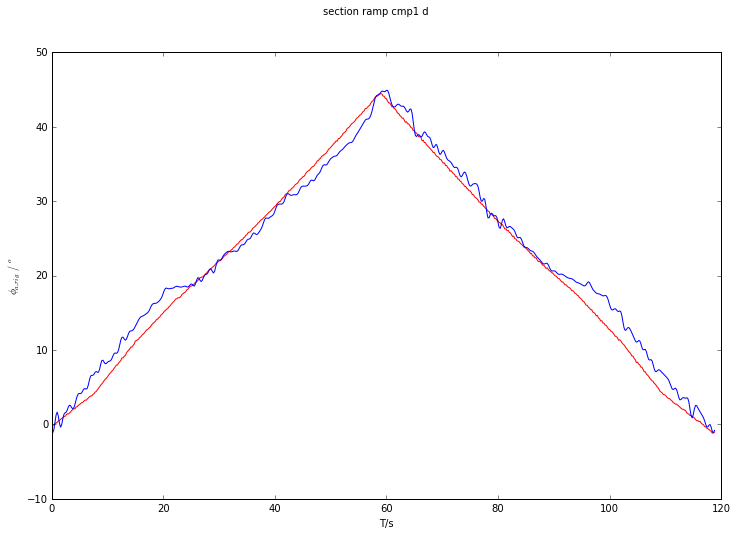

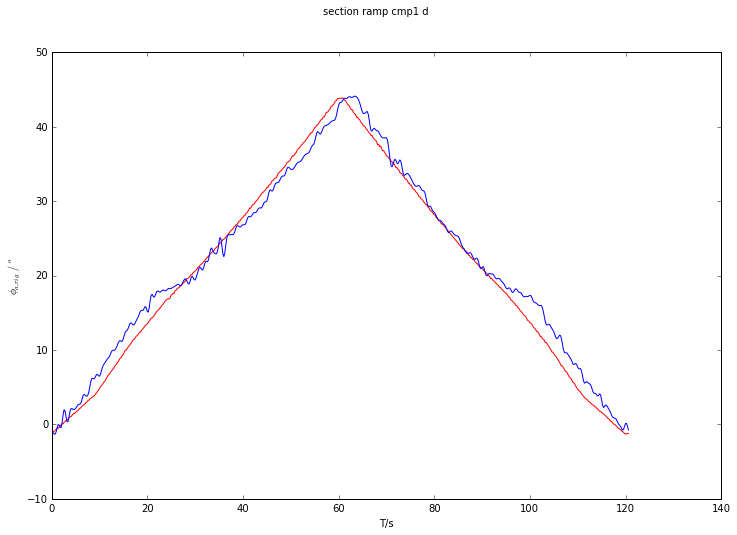

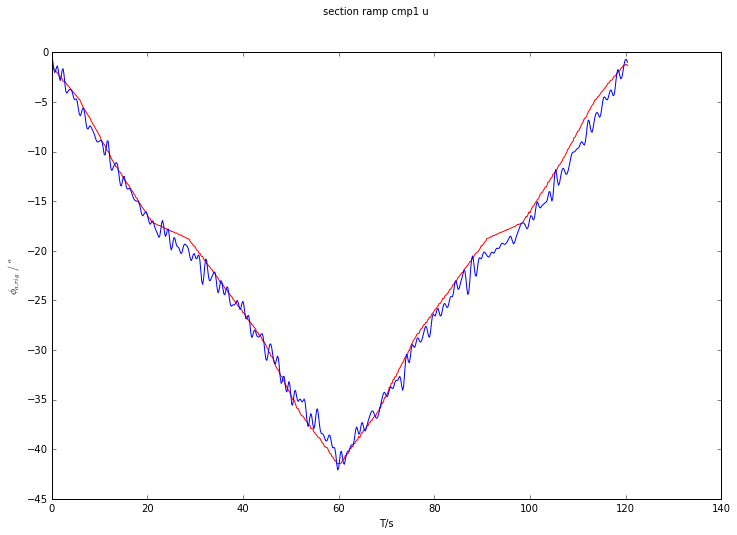

In [24]:
display_opt_params()

# show result
idx = [0,1, 8,9,
       2,3,10,
       4,5,11,12,
       6,7,13,14,]
display_data_for_test();

update_guess();

angeles = 
[-41, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 41]
Clda_cmpx = 
[[ 0.06082331  0.05267211  0.04570094  0.03833534  0.03117964  0.0245108
   0.01619857  0.00634454 -0.00596277 -0.01528365 -0.02303881 -0.02526612
  -0.0317685  -0.03811142 -0.04673862 -0.05333779]
 [ 0.04788942  0.04008188  0.03330381  0.02750476  0.02218884  0.01852654
   0.0127498   0.00595321 -0.00571214 -0.01126245 -0.0175576  -0.02127933
  -0.02612283 -0.03235035 -0.03927577 -0.04783036]
 [ 0.04155991  0.03667208  0.0313992   0.02575806  0.02075753  0.01597812
   0.01257065  0.0067306  -0.00495984 -0.01014643 -0.01580438 -0.02157629
  -0.02600116 -0.03111442 -0.03538683 -0.03985045]
 [ 0.03593593  0.03212328  0.02837192  0.02451539  0.02009681  0.01636397
   0.01076834  0.0057647  -0.00461214 -0.00980298 -0.01346834 -0.01592695
  -0.02018917 -0.02496222 -0.03053361 -0.03670969]]


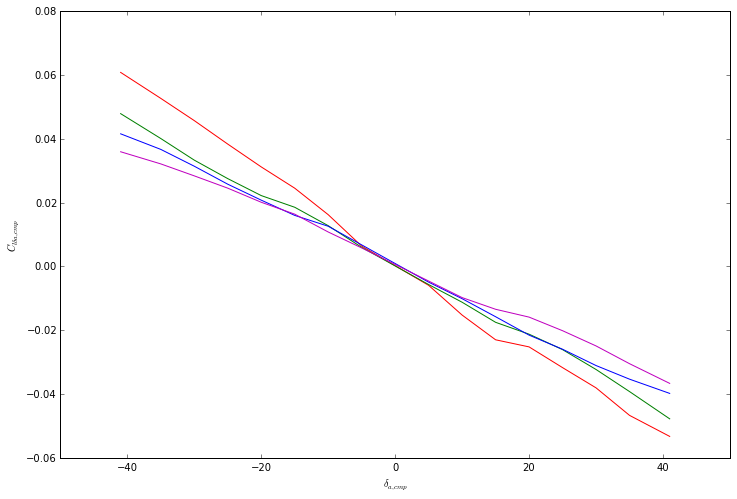

In [25]:
res_params = res['x']
params = param0[:]
for i,j in enumerate(opt_idx):
    params[j] = res_params[i]

k1 = np.array(params[0:angles_num])
k2 = np.array(params[angles_num:angles_num*2])
k3 = np.array(params[angles_num*2:angles_num*3])
k4 = np.array(params[angles_num*3:angles_num*4])

Clda_cmp1 = Clda_cmp*0.00436332313*k1*angles
Clda_cmp2 = Clda_cmp*0.00436332313*k2*angles
Clda_cmp3 = Clda_cmp*0.00436332313*k3*angles
Clda_cmp4 = Clda_cmp*0.00436332313*k4*angles

print('angeles = ')
print(angles)
print('Clda_cmpx = ')
print(np.vstack((Clda_cmp1,Clda_cmp2,Clda_cmp3,Clda_cmp4)))

%matplotlib inline
plt.figure(figsize=(12,8),dpi=300)
plt.plot(angles,  Clda_cmp1, 'r')
plt.plot(angles,  Clda_cmp2, 'g')
plt.plot(angles,  Clda_cmp3, 'b')
plt.plot(angles,  Clda_cmp4, 'm')
plt.xlabel('$\delta_{a,cmp}$')
plt.ylabel('$C_{l \delta a,cmp}$')
plt.show()

In [ ]:
toggle_inputs()
button_qtconsole()